In [348]:
print("      ")

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import re

from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional, Flatten
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAIRAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read the data

In [4]:
train = pd.read_csv('./BBC News Train.csv')
print(f"Number of data points {train.shape[0]}")
print(f"Number of features    {train.shape[1]}")
train.head()

Number of data points 1490
Number of features    3


ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

business         336
tech             261
politics         274
sport            346
entertainment    273
Name: Category, dtype: int64


business         0.225503
tech             0.175168
politics         0.183893
sport            0.232215
entertainment    0.183221
Name: Category, dtype: float64


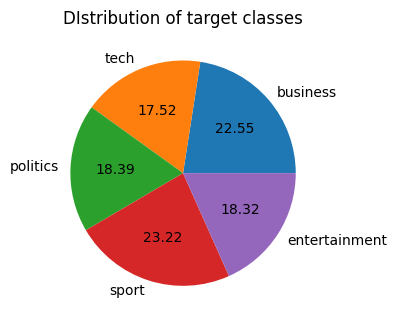

In [29]:
print(train['Category'].value_counts(sort=False))
print('\n')
print(train['Category'].value_counts(normalize=True, sort=False))

plt.figure(figsize=(4,4))
plt.pie(train['Category'].value_counts(sort=False), autopct='%.2f', labels=train['Category'].unique())
plt.title("DIstribution of target classes")
plt.tight_layout()

In [38]:
max_word_count = np.max([len(rec.split()) for rec in train['Text']])
min_word_count = np.min([len(rec.split()) for rec in train['Text']])
avg_word_count = np.mean([len(rec.split()) for rec in train['Text']])

print(min_word_count, avg_word_count, max_word_count)

90 385.01275167785235 3345


Function to retrun the number of words in the sentence

In [39]:
def get_word_count(text):
    return len(text.split())

Apply the function on the feature Text 

In [41]:
train['word_count'] = train['Text'].apply(lambda x: get_word_count(x))
train.head()

ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   word_count  
0         301  
1         325  
2         514  
3         634  
4         355

In [48]:
train[train['word_count'] > 3000]

ArticleId                                               Text  Category  \
1057        678  minimum wage increased to £5.05 the minimum wa...  politics   

      word_count  
1057        3345

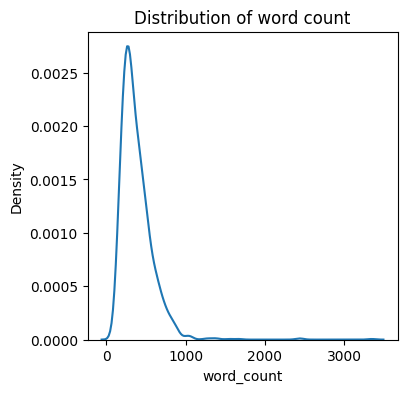

In [56]:
plt.figure(figsize=(4,4))
sns.kdeplot(train['word_count'])
plt.title('Distribution of word count')
plt.show()

Clearly sentences more than 1000 words are very less

In [60]:
print(f"# of Text more than 2k words {len(train[train['word_count'] > 2000])}")
print(f"# of Text more than 1k words {len(train[train['word_count'] > 1000])}")
print(f"# of Text more than .9k words {len(train[train['word_count'] > 900])}")

# of Text more than 2k words 3
# of Text more than 1k words 15
# of Text more than .9k words 21


Drop the 15 sentences having more than 1K words

In [63]:
train_v1 = train[train['word_count'] < 1000].copy(deep=True)
print(len(train_v1))

1475


Function to preprocess text

In [114]:
def text_processing(text,
                    punctuation = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~+=`'''
                    ) -> list:
    
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    stop_words.remove('no')
    
    for char in text.lower():
        if char in punctuation:
            text = text.replace(char, '')

    #Remove words if they contain number
    '''
    The "\w" means "any word character" which usually means alphanumeric (letters, numbers, regardless of case) plus underscore (_)
    The "^" "anchors" to the beginning of a string, and the "$" "anchors" To the end of a string, which means that, 
    in this case, the match must start at the beginning of a string and end at the end of the string.
    '''
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Removing digits
    text = re.sub(r'[0-9]+', '', text)
    
    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    #Lower case
    text = text.lower()
    
    #Convert each word to a list
    text = text.split()
    
    text = ' '.join([word for word in text if word != '' and word not in stop_words])
    
    return text

# get POS Tag for word
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatizing the data
# Steps to convert : Document -> Sentences -> Tokens -> POS -> Lemmas
ps = PorterStemmer()
def stem_clean_text(text, cores = 1):
 
    sample = text
    sample = sample.split()
    sample = [ps.stem(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ' '.join(sample)
    
    return sample

In [115]:
print("Pre-processing")
print(train_v1['Text'].head())

 
train_v1['Text'] = train_v1['Text'].apply(text_processing)
print(train_v1['Text'].head())

print('\n Stemming')
#data['reviews'] = data['reviews'].apply(stem_clean_text)
print(train_v1['Text'].head())


Pre-processing
0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses payout eighteen former enron dire...
Name: Text, dtype: object
0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses payout eighteen former enron dire...
Name: Text, dtype: object

 Stemming
0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses payout eighteen former enron dire...
Name: Text, dtype: object


In [116]:
train_v1['word_count_after_cleaning'] = train_v1['Text'].apply(lambda x : get_word_count(x))
print(np.min(train_v1['word_count_after_cleaning']), np.mean(train_v1['word_count_after_cleaning']), np.max(train_v1['word_count_after_cleaning']))

47 206.36610169491524 549


Unique_Vocab

In [122]:
all_text = []
unique_vocab = set()

for rec in train_v1['Text']:
    all_text.append(rec.split())
    
    for word in rec.split():
        if word not in unique_vocab:
            unique_vocab.add(word)
    
print(f"Number of documents in the corpus {len(all_text)}")
print(f"Number of unique words in the vacabulary {len(unique_vocab)}")

unique_vocab = sorted(unique_vocab)   
print(unique_vocab[0:5])

vocab_dict = {}
for idx, char in enumerate(unique_vocab):
    vocab_dict.update({char:idx})

print(len(vocab_dict))
    

Number of documents in the corpus 1475
Number of unique words in the vacabulary 24524
['aa', 'aaa', 'aaas', 'aac', 'aadc']
24524


Encode the sentences using the vocab_dict

In [167]:
encoded_text = []
for sent in train_v1['Text']:
    encoded_text.append([vocab_dict[word] for word in sent.split()])
    
encoded_text

[[24242,
  7486,
  12283,
  5585,
  12313,
  5593,
  8508,
  24242,
  3729,
  2116,
  6791,
  1888,
  8634,
  3628,
  3138,
  4296,
  23986,
  8209,
  24149,
  5296,
  4772,
  24242,
  7557,
  11198,
  148,
  569,
  6073,
  11373,
  148,
  16610,
  23222,
  21780,
  9081,
  23728,
  12383,
  4143,
  8205,
  8422,
  6142,
  24522,
  148,
  8634,
  14243,
  6791,
  16333,
  9540,
  3628,
  8634,
  4598,
  17047,
  12313,
  1168,
  14243,
  6791,
  15280,
  19523,
  148,
  22512,
  24242,
  15285,
  7059,
  10067,
  7614,
  10958,
  18381,
  13578,
  23665,
  21038,
  6746,
  7360,
  14246,
  4772,
  18837,
  4631,
  3041,
  22206,
  11768,
  14616,
  24425,
  23844,
  7701,
  1469,
  1242,
  834,
  1106,
  24242,
  148,
  6737,
  18917,
  834,
  9137,
  9412,
  12579,
  16898,
  16610,
  23232,
  24242,
  14243,
  6790,
  12313,
  18917,
  22833,
  8634,
  1170,
  1469,
  568,
  16894,
  14246,
  4772,
  692,
  18917,
  19655,
  13580,
  14243,
  6791,
  15095,
  15761,
  21740,
  17305,

In [170]:
np.max([len(rec) for rec in encoded_text]), np.min([len(rec) for rec in encoded_text])

(549, 47)

Post padding the sentences to make the length consistent

In [265]:
padding_length = 150
padded_encoded_text = []

for rec in encoded_text:
    dff_len = padding_length - len(rec)
    
    if dff_len <= 0:
        padded_encoded_text.append(rec[:padding_length])
    else:
        padd_seq = [0] * dff_len
        padded_encoded_text.append(rec + padd_seq)

print(len(encoded_text), len(padded_encoded_text))

1475 1475


In [266]:
padded_encoded_text[0]

[24242,
 7486,
 12283,
 5585,
 12313,
 5593,
 8508,
 24242,
 3729,
 2116,
 6791,
 1888,
 8634,
 3628,
 3138,
 4296,
 23986,
 8209,
 24149,
 5296,
 4772,
 24242,
 7557,
 11198,
 148,
 569,
 6073,
 11373,
 148,
 16610,
 23222,
 21780,
 9081,
 23728,
 12383,
 4143,
 8205,
 8422,
 6142,
 24522,
 148,
 8634,
 14243,
 6791,
 16333,
 9540,
 3628,
 8634,
 4598,
 17047,
 12313,
 1168,
 14243,
 6791,
 15280,
 19523,
 148,
 22512,
 24242,
 15285,
 7059,
 10067,
 7614,
 10958,
 18381,
 13578,
 23665,
 21038,
 6746,
 7360,
 14246,
 4772,
 18837,
 4631,
 3041,
 22206,
 11768,
 14616,
 24425,
 23844,
 7701,
 1469,
 1242,
 834,
 1106,
 24242,
 148,
 6737,
 18917,
 834,
 9137,
 9412,
 12579,
 16898,
 16610,
 23232,
 24242,
 14243,
 6790,
 12313,
 18917,
 22833,
 8634,
 1170,
 1469,
 568,
 16894,
 14246,
 4772,
 692,
 18917,
 19655,
 13580,
 14243,
 6791,
 15095,
 15761,
 21740,
 17305,
 4296,
 8141,
 3729,
 9139,
 2762,
 941,
 17047,
 20776,
 24149,
 8508,
 24242,
 8144,
 3729,
 19208,
 21265,
 18917,


Encode the labels

In [267]:
print(train_v1['Category'].nunique(), '\n', train_v1['Category'].unique())


target_dict = {}
for i,key in enumerate(sorted(train_v1['Category'].unique())):
    target_dict.update({key:i})

print(target_dict)

train_v1['label'] = train_v1['Category'].map(target_dict)
train_v1.head()

5 
 ['business' 'tech' 'politics' 'sport' 'entertainment']
{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


ArticleId                                               Text  Category  \
0       1833  worldcom exboss launches defence lawyers defen...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens maj...  business   
3       1976  lifestyle governs mobile choice faster better ...      tech   
4        917  enron bosses payout eighteen former enron dire...  business   

   word_count  word_count_after_cleaning  label  
0         301                        183      0  
1         325                        194      0  
2         514                        267      0  
3         634                        344      4  
4         355                        199      0

Convery the input and output to array

In [268]:
X = np.asarray(padded_encoded_text)
Y = np.asarray(train_v1['label'])

print(X.shape, Y.shape)

(1475, 150) (1475,)


Train-Test split

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1702)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) 

(1180, 150) (1180,)
(295, 150) (295,)


In [270]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) 

(1180, 150, 1) (1180, 1)
(295, 150, 1) (295, 1)


Simple RNN

In [275]:
model = Sequential()
model.add(Embedding(len(vocab_dict), 128, input_length=150))
model.add(SimpleRNN(units=128, input_shape=(150,1), return_sequences=True))
model.add(SimpleRNN(units=64))
model.add(Dense(units=50))
model.add(Dense(units=32))
model.add(Dense(units=5, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 150, 128)          3139072   
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 150, 128)          32896     
                                                                 
 simple_rnn_30 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dense_67 (Dense)            (None, 50)                3250      
                                                                 
 dense_68 (Dense)            (None, 32)                1632      
                                                                 
 dense_69 (Dense)            (None, 5)                 165       
                                                                 
Total params: 3,189,367
Trainable params: 3,189,367
N

In [276]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
37/37 [==============================] - 7s 137ms/step - loss: 1.6025 - accuracy: 0.2483 - val_loss: 1.5769 - val_accuracy: 0.3051
Epoch 2/20
37/37 [==============================] - 5s 130ms/step - loss: 1.3611 - accuracy: 0.4458 - val_loss: 1.4658 - val_accuracy: 0.3492
Epoch 3/20
37/37 [==============================] - 4s 118ms/step - loss: 0.6713 - accuracy: 0.7839 - val_loss: 1.4962 - val_accuracy: 0.3898
Epoch 4/20
37/37 [==============================] - 4s 110ms/step - loss: 0.1882 - accuracy: 0.9381 - val_loss: 1.8245 - val_accuracy: 0.3763
Epoch 5/20
37/37 [==============================] - 4s 104ms/step - loss: 0.1473 - accuracy: 0.9508 - val_loss: 1.8639 - val_accuracy: 0.3559
Epoch 6/20
37/37 [==============================] - 4s 107ms/step - loss: 0.0428 - accuracy: 0.9898 - val_loss: 2.1618 - val_accuracy: 0.3525
Epoch 7/20
37/37 [==============================] - 4s 109ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 2.4160 - val_accuracy: 0.3627
Epoch 

Clearly as the sequence lenght is decrease, accuracy increases <br>
seq-length = 550 - accuracy = 20% <br>
seq-length = 200 - accuracy = 25% <br>
seq-length = 150 - accuracy = 35% <br>

However model is overfitting

In [277]:
model.predict(X_test)[0]

10/10 [==============================] - 1s 31ms/step


array([0.00413963, 0.08769721, 0.09035954, 0.79414505, 0.02365858],
      dtype=float32)

In [278]:
y_test[0]

array([1], dtype=int64)

LSTM

In [286]:
lstm_model = Sequential()
lstm_model.add(Embedding(len(vocab_dict), 128, input_length=150))
#model.add(LSTM(units=128, input_shape=(550,1), return_sequences=True))
lstm_model.add(LSTM(units=128, return_sequences=True))
lstm_model.add(LSTM(units=64))
lstm_model.add(Dense(units=50))
lstm_model.add(Dense(units=32))
lstm_model.add(Dense(units=5, activation='softmax'))

lstm_model.summary()

lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 150, 128)          3139072   
                                                                 
 lstm_24 (LSTM)              (None, 150, 128)          131584    
                                                                 
 lstm_25 (LSTM)              (None, 64)                49408     
                                                                 
 dense_79 (Dense)            (None, 50)                3250      
                                                                 
 dense_80 (Dense)            (None, 32)                1632      
                                                                 
 dense_81 (Dense)            (None, 5)                 165       
                                                                 
Total params: 3,325,111
Trainable params: 3,325,111
N

In [287]:
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
37/37 [==============================] - 16s 344ms/step - loss: 1.4504 - accuracy: 0.3271 - val_loss: 1.2522 - val_accuracy: 0.4068
Epoch 2/20
37/37 [==============================] - 12s 331ms/step - loss: 1.1637 - accuracy: 0.4322 - val_loss: 1.1312 - val_accuracy: 0.3797
Epoch 3/20
37/37 [==============================] - 12s 328ms/step - loss: 0.8326 - accuracy: 0.6771 - val_loss: 0.7227 - val_accuracy: 0.6881
Epoch 4/20
37/37 [==============================] - 12s 333ms/step - loss: 0.4366 - accuracy: 0.8492 - val_loss: 0.4483 - val_accuracy: 0.8475
Epoch 5/20
37/37 [==============================] - 12s 322ms/step - loss: 0.1850 - accuracy: 0.9449 - val_loss: 0.5020 - val_accuracy: 0.8373
Epoch 6/20
37/37 [==============================] - 12s 316ms/step - loss: 0.3277 - accuracy: 0.9059 - val_loss: 0.9581 - val_accuracy: 0.7627
Epoch 7/20
37/37 [==============================] - 11s 310ms/step - loss: 0.5754 - accuracy: 0.8000 - val_loss: 0.9366 - val_accuracy: 0.6542

In [290]:
y_hat = lstm_model.predict(X_test)
y_hat

10/10 [==============================] - 1s 137ms/step


array([[6.3986890e-04, 1.7317319e-03, 2.2651207e-05, 9.9758518e-01,
        2.0574575e-05],
       [9.4097674e-01, 6.6411310e-05, 1.3625248e-03, 5.6866873e-02,
        7.2748103e-04],
       [1.1521232e-03, 1.1052832e-03, 3.0842297e-05, 9.9769068e-01,
        2.1115178e-05],
       ...,
       [8.3973842e-05, 1.0310457e-04, 7.8447847e-05, 6.7647881e-07,
        9.9973375e-01],
       [1.5316353e-05, 9.8992050e-01, 9.1827633e-03, 3.4266195e-04,
        5.3868617e-04],
       [2.2596894e-05, 9.9050152e-01, 5.0805500e-03, 1.8057245e-04,
        4.2148009e-03]], dtype=float32)

In [302]:
y_hat_final = []
for pred in y_hat:
    y_hat_final.append(np.argmax(pred))
y_hat_final[0:5]

[3, 0, 3, 2, 3]

In [303]:
confusion_matrix(y_test, y_hat_final)

array([[51,  0,  5,  0,  0],
       [ 2, 46,  7,  3,  0],
       [ 4,  0, 50,  0,  0],
       [ 3,  1,  1, 68,  1],
       [ 1, 11,  2,  0, 39]], dtype=int64)

Bidirectionl LSTM

In [306]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(len(vocab_dict), 128, input_length=150))
#model.add(LSTM(units=128, input_shape=(550,1), return_sequences=True))
bi_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(units=64)))
bi_lstm_model.add(Dense(units=50))
bi_lstm_model.add(Dense(units=32))
bi_lstm_model.add(Dense(units=5, activation='softmax'))

bi_lstm_model.summary()

bi_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 150, 128)          3139072   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 256)         263168    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_85 (Dense)            (None, 50)                6450      
                                                                 
 dense_86 (Dense)            (None, 32)                1632      
                                                                 
 dense_87 (Dense)            (None, 5)               

In [307]:
bi_lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
37/37 [==============================] - 49s 891ms/step - loss: 1.2606 - accuracy: 0.4517 - val_loss: 0.5379 - val_accuracy: 0.8610
Epoch 2/20
37/37 [==============================] - 32s 863ms/step - loss: 0.2302 - accuracy: 0.9297 - val_loss: 0.2926 - val_accuracy: 0.9186
Epoch 3/20
37/37 [==============================] - 32s 858ms/step - loss: 0.0520 - accuracy: 0.9805 - val_loss: 0.2206 - val_accuracy: 0.9458
Epoch 4/20
37/37 [==============================] - 31s 850ms/step - loss: 0.0354 - accuracy: 0.9890 - val_loss: 0.2461 - val_accuracy: 0.9254
Epoch 5/20
37/37 [==============================] - 32s 861ms/step - loss: 0.0146 - accuracy: 0.9966 - val_loss: 0.1830 - val_accuracy: 0.9559
Epoch 6/20
37/37 [==============================] - 32s 857ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1844 - val_accuracy: 0.9559
Epoch 7/20
37/37 [==============================] - 31s 850ms/step - loss: 8.3954e-04 - accuracy: 1.0000 - val_loss: 0.1901 - val_accuracy: 0.

In [309]:
y_hat = bi_lstm_model.predict(X_test)
y_hat

10/10 [==============================] - 5s 299ms/step


array([[1.1538266e-04, 9.9981159e-01, 7.2287236e-05, 5.9275914e-07,
        1.2438767e-07],
       [9.9996769e-01, 3.0783125e-05, 7.7708207e-10, 1.6172584e-07,
        1.2794256e-06],
       [1.2180311e-05, 1.3930843e-06, 2.2819078e-05, 9.9994206e-01,
        2.1493694e-05],
       ...,
       [2.8985134e-05, 4.4058652e-08, 1.2727427e-05, 5.8285023e-06,
        9.9995244e-01],
       [1.6824718e-04, 9.9980110e-01, 3.0207259e-05, 3.4818643e-07,
        8.7107310e-08],
       [2.1894732e-04, 9.9940526e-01, 3.7088626e-04, 1.1630859e-07,
        4.7921144e-06]], dtype=float32)

In [310]:
y_hat_final = []
for pred in y_hat:
    y_hat_final.append(np.argmax(pred))
y_hat_final[0:5]

[1, 0, 3, 2, 3]

In [311]:
confusion_matrix(y_test, y_hat_final)

array([[55,  0,  0,  0,  1],
       [ 2, 53,  2,  0,  1],
       [ 1,  0, 53,  0,  0],
       [ 0,  0,  0, 74,  0],
       [ 2,  1,  2,  0, 48]], dtype=int64)

Bidirectional LSTM gives excellant results

- Lets repeat the last experiment with categorical_crossentropy instead of spare_categorical_crossentropy
- For this convert the Y into one hot representation

In [336]:
Y_new = to_categorical(Y, num_classes=5)

X_train, X_test, y_train, y_test = train_test_split(X, Y_new, test_size=0.2, random_state=1702)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) 

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0],5))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0],5))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) 

(1180, 150) (1180, 5)
(295, 150) (295, 5)
(1180, 150, 1) (1180, 5)
(295, 150, 1) (295, 5)


In [338]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(len(vocab_dict), 128, input_length=150))
#model.add(LSTM(units=128, input_shape=(550,1), return_sequences=True))
bi_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(units=64)))
bi_lstm_model.add(Dense(units=50))
bi_lstm_model.add(Dense(units=32))
bi_lstm_model.add(Dense(units=5, activation='softmax'))

bi_lstm_model.summary()

bi_lstm_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 150, 128)          3139072   
                                                                 
 bidirectional_4 (Bidirectio  (None, 150, 256)         263168    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_88 (Dense)            (None, 50)                6450      
                                                                 
 dense_89 (Dense)            (None, 32)                1632      
                                                                 
 dense_90 (Dense)            (None, 5)               

In [339]:
bi_lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
37/37 [==============================] - 45s 975ms/step - loss: 1.2537 - accuracy: 0.5017 - val_loss: 0.6100 - val_accuracy: 0.7695
Epoch 2/20
37/37 [==============================] - 32s 867ms/step - loss: 0.1970 - accuracy: 0.9415 - val_loss: 0.1833 - val_accuracy: 0.9525
Epoch 3/20
37/37 [==============================] - 33s 890ms/step - loss: 0.0268 - accuracy: 0.9941 - val_loss: 0.1630 - val_accuracy: 0.9627
Epoch 4/20
37/37 [==============================] - 53s 1s/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.1998 - val_accuracy: 0.9525
Epoch 5/20
37/37 [==============================] - 54s 1s/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.1640 - val_accuracy: 0.9627
Epoch 6/20
37/37 [==============================] - 29s 777ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9559
Epoch 7/20
37/37 [==============================] - 36s 982ms/step - loss: 5.7995e-04 - accuracy: 1.0000 - val_loss: 0.1677 - val_accuracy: 0.9593
E

In [340]:
y_hat = bi_lstm_model.predict(X_test)
y_hat

10/10 [==============================] - 4s 226ms/step


array([[1.6567906e-04, 9.9974030e-01, 4.4768487e-09, 2.2929404e-05,
        7.1182963e-05],
       [9.9979740e-01, 1.9995270e-04, 2.6428338e-06, 1.5985156e-08,
        1.9270788e-08],
       [7.1519506e-09, 2.3206214e-05, 5.4066863e-05, 9.9988520e-01,
        3.7451911e-05],
       ...,
       [1.6498731e-07, 1.2490601e-07, 1.1424332e-06, 4.8062356e-07,
        9.9999809e-01],
       [1.2361772e-04, 9.9968827e-01, 8.4140597e-09, 4.2986088e-05,
        1.4510933e-04],
       [1.2009876e-03, 9.9508190e-01, 3.6062504e-09, 3.2239848e-06,
        3.7140006e-03]], dtype=float32)

In [341]:
y_hat_final = []
for pred in y_hat:
    y_hat_final.append(np.argmax(pred))
y_hat_final[0:5]

[1, 0, 3, 2, 3]

[1,
 0,
 3,
 2,
 3,
 2,
 2,
 1,
 4,
 1,
 3,
 1,
 4,
 4,
 0,
 2,
 1,
 4,
 3,
 2,
 2,
 1,
 3,
 0,
 4,
 2,
 1,
 0,
 4,
 0,
 1,
 0,
 3,
 4,
 4,
 3,
 1,
 1,
 0,
 1,
 1,
 4,
 1,
 3,
 0,
 1,
 0,
 4,
 4,
 3,
 3,
 3,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 3,
 4,
 4,
 4,
 4,
 1,
 0,
 2,
 3,
 3,
 2,
 4,
 1,
 2,
 0,
 3,
 1,
 2,
 0,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 2,
 3,
 4,
 2,
 1,
 3,
 0,
 3,
 1,
 4,
 4,
 1,
 0,
 3,
 1,
 2,
 3,
 4,
 0,
 1,
 3,
 3,
 1,
 2,
 1,
 3,
 4,
 3,
 1,
 4,
 2,
 4,
 0,
 1,
 1,
 4,
 4,
 4,
 0,
 2,
 3,
 3,
 3,
 0,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 3,
 1,
 2,
 1,
 3,
 0,
 2,
 2,
 1,
 2,
 0,
 4,
 1,
 0,
 0,
 2,
 4,
 4,
 1,
 2,
 0,
 3,
 3,
 3,
 0,
 2,
 4,
 4,
 2,
 3,
 2,
 1,
 0,
 3,
 0,
 3,
 2,
 2,
 4,
 0,
 4,
 4,
 1,
 4,
 2,
 1,
 2,
 4,
 1,
 1,
 0,
 4,
 3,
 0,
 4,
 3,
 3,
 3,
 4,
 3,
 0,
 0,
 0,
 4,
 1,
 1,
 2,
 3,
 0,
 4,
 2,
 0,
 2,
 3,
 3,
 0,
 3,
 2,
 2,
 3,
 0,
 3,
 0,
 2,
 2,
 2,
 3,
 3,
 1,
 3,
 3,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 4,
 0,
 4,
 3,
 1,
 4,
 1,
 1,
 3,
 4,
 2,


In [347]:
confusion_matrix([np.argmax(rec) for rec in y_test], y_hat_final)

array([[53,  1,  1,  0,  1],
       [ 1, 55,  0,  2,  0],
       [ 1,  0, 52,  1,  0],
       [ 0,  0,  0, 74,  0],
       [ 1,  2,  0,  1, 49]], dtype=int64)

No difference in accuracy betweeen sparase categorical cross entropy & categorical cross entropy